# Text analysis
## r/conspiracy comments containing "vaccine"
**Group members**
* Maheep T
* Sanchi S
***

## Import modules

In [29]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt
import re
import string
from dfply import *
import preprocessor as p
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords, wordnet
from nltk.stem import PorterStemmer
from collections import Counter
from kwic import keywords_in_context
from operator import itemgetter
from datetime import datetime as dt
from keyness import log_likelihood

# download
# nltk.download
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')

## Read files

In [2]:
base_dir = 'C:\\Users\\Maheep\\Documents\\TUM\\WiSe2020\\CSS\\code' #import os; os.getcwd()

filename = base_dir + "\\" + "comments_vaccine_praw.csv" # comments_vaccine/_praw.csv
df_com = pd.read_csv(filename)
df_com = df_com.rename({'Submission ID': 's_id', 'Comment ID': 'c_id', 'Body': 'text', 'Publish Date': 'date', 'Author': 'user', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = base_dir + "\\" + "submissions_vaccine.csv"
df_sub = pd.read_csv(filename)
df_sub = df_sub.rename({'Post ID': 's_id', 'Title': 'text', 'Publish Date': 'date', 'Score': 'score', 'Permalink': 'link'}, axis=1)

filename = base_dir + "\\" + "reddit_bots.csv"
df_bots = pd.read_csv(filename)
list_bots = df_bots['Name'].tolist() ;

In [3]:
# out_file for temp output
out_file = base_dir + "\\" + "out_file.csv"

## Collect Data

* Use pushshift to query "vaccine" submissions (reddit posts)

In [4]:
print(df_sub.shape[0], " rows in submission data")

2905  rows in submission data


* Use PRAW to collect comments by iterating over all "vaccine" submissions
([praw docs](https://praw.readthedocs.io/en/latest/tutorials/comments.html))
    * pushshift comment data has a lot of missing values ([Gaffney, Matias 2018](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0200162) )

In [5]:
print(df_com.shape[0], "rows in comment data")

77366 rows in comment data


## Clean-up and pre-processing

* Remove comments -
  * where user and text were [deleted]
  * where user is a  bot (list of bots from [Klein et. al. 2019](https://journals.plos.org/plosone/article?id=10.1371%2Fjournal.pone.0225098) )

In [6]:
df_com['date'] =  df_com['date'].apply(lambda x: dt.strptime(x,'%Y-%m-%d %H:%M:%S')) # convert str to datetime
df_com_pp = df_com.copy() # copy to pre-process dataframe
df_com_pp = df_com_pp >> mask(~((X.user == '[deleted]') & (X.text == '[deleted]'))) # >> summarize(count=n(X.c_id))
df_com_pp = df_com_pp[~df_com_pp['user'].isin(list_bots)]

* Clean - removes URLs, Hashtags, Mentions, Reserved words (RT, FAV), Emojis, Smileys ([Source](https://pypi.org/project/tweet-preprocessor/))

In [7]:
def func_clean(text):
    text = re.sub(r'[\r|\n|\r\n]+', " ",text) # remove extra newlines
    text = p.clean(text) # from preprocessor lib
    return text
    
df_com_pp['text'] = df_com_pp['text'].apply(func_clean)

* Expanding contractions ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [8]:
from contractions import CONTRACTION_MAP
import re

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    
    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

df_com_pp['text'] = df_com_pp['text'].apply(expand_contractions)

* Tokenise <= lowercase + remove punctuation ([Source](https://towardsdatascience.com/basic-tweet-preprocessing-in-python-efd8360d529e))

In [9]:
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.lower()) # lowercase
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation))) # remove punctuation

tt = TweetTokenizer() # does better than default word_tokenizer
df_com_pp['text'] = df_com_pp['text'].apply(tt.tokenize) 

* Fix repetition in words e.g. "Coooolll!" => "Cool!" ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch03%20-%20Processing%20and%20Understanding%20Text/Ch03a%20-%20Text%20Wrangling.ipynb))

In [10]:
def remove_repeated_characters(tokens):
    repeat_pattern = re.compile(r'(\w*)(\w)\2(\w*)')
    match_substitution = r'\1\2\3'
    def replace(old_word):
        if wordnet.synsets(old_word):
            return old_word
        new_word = repeat_pattern.sub(match_substitution, old_word)
        return replace(new_word) if new_word != old_word else new_word
            
    correct_tokens = [replace(word) for word in tokens]
    return correct_tokens

df_com_pp['text'] = df_com_pp['text'].apply(remove_repeated_characters)

* Remove stopwords

In [11]:
stop_words = stopwords.words('english')
def func_filter_stopwords(l):
    return list([w for w in l if not w in stop_words])
df_com_pp['text'] = df_com_pp['text'].apply(func_filter_stopwords)

* Stemming (not lemmatising as it needs the whole sentence context to be effective)

In [12]:
ps = PorterStemmer()
df_com_pp['text'] = df_com_pp['text'].apply(lambda x: [ps.stem(word) for word in x])

## Explore the data

* Weekly comment frequency on "vaccine" posts

In [1]:
df_com_pp['week'] = pd.to_datetime(df_com_pp['date']).dt.isocalendar().week
df_new = df_com_pp.groupby('week').size()

fig = plt.figure(figsize=[10,8])
ax = plt.subplot()
ax = df_new.plot.barh()
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of comments on "vaccine" posts on r/conspiracy')
ax.set_title('Weekly comment frequency')
# #plt.grid()
plt.show()
# plt.cla()
# plt.clf()
# plt.close()

NameError: name 'pd' is not defined

* Weekly comment frequency of comments mentioning "bill gate"

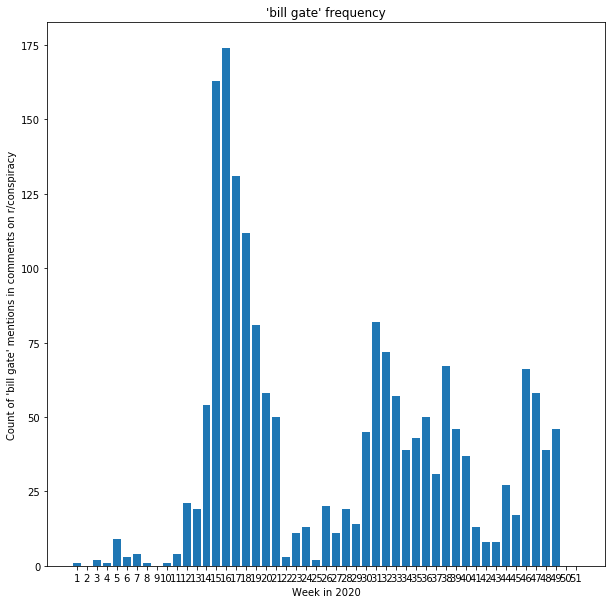

In [15]:
def func_gates(x):
    return True if (('bill' in x) & ('gate' in x)) else False
df_com_pp['gates'] = df_com_pp['text'].apply(lambda x: func_gates(x))
df_com_pp >> filter_by(X.gates == True)
df_new = df_com_pp.groupby('week').agg({'gates' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['gates'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'bill gate\' mentions in comments on r/conspiracy')
ax.set_title('\'bill gate\' frequency')
# #plt.grid()
plt.show()

* Weekly comment frequency of comments mentioning "side effect"

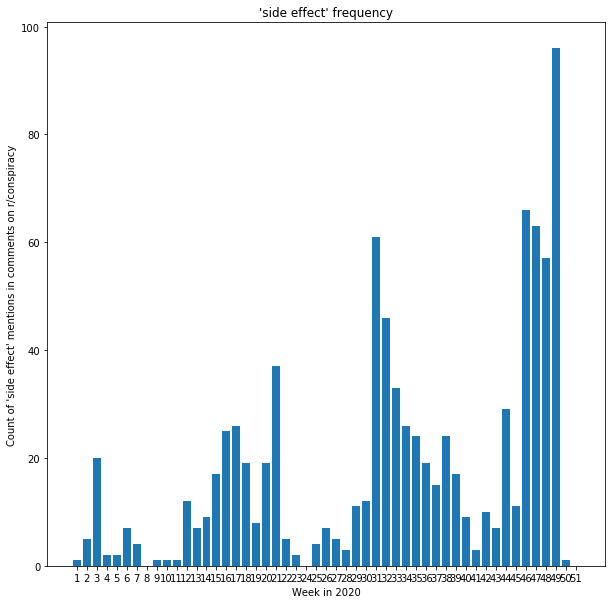

In [27]:
def func_effect(x):
    return True if (('side' in x) & ('effect' in x)) else False
df_com_pp['effect'] = df_com_pp['text'].apply(lambda x: func_effect(x))
df_new = df_com_pp.groupby('week').agg({'effect' : "sum"})


fig, ax = plt.subplots()
fig.set_size_inches([10,10])
#ax = df_new.plot.bar(y='gates')
ax.bar(df_new.index,df_new['effect'].tolist())
ax.set_xticks(df_new.index.tolist())
ax.set_xlabel('Week in 2020')
ax.set_ylabel('Count of \'side effect\' mentions in comments on r/conspiracy')
ax.set_title('\'side effect\' frequency')
# #plt.grid()
plt.show()

* Most important words/phrases ([Source](https://github.com/Apress/text-analytics-w-python-2e/blob/master/Ch06%20-%20Text%20Summarization%20and%20Topic%20Models/Ch06a%20-%20Text%20Keyphrase%20Extraction.ipynb))

In [17]:
def compute_ngrams(sequence, n):
    return list(
            zip(*(sequence[index:] 
                     for index in range(n)))
    )

def get_top_ngrams(tokens, ngram_val=1, limit=5):

    ngrams = compute_ngrams(tokens, ngram_val)
    ngrams_freq_dist = nltk.FreqDist(ngrams)
    sorted_ngrams_fd = sorted(ngrams_freq_dist.items(), 
                              key=itemgetter(1), reverse=True)
    sorted_ngrams = sorted_ngrams_fd[0:limit]
    sorted_ngrams = [(' '.join(text), freq) 
                     for text, freq in sorted_ngrams]

    return sorted_ngrams
list_tokens_flattened = [token for text in df_com_pp['text'].tolist() for token in text]
#get_top_ngrams(list_tokens_flattened,2,10)

In [18]:
get_top_ngrams(list_tokens_flattened,2,10)

[('bill gate', 1941),
 ('covid 19', 1618),
 ('get vaccin', 1341),
 ('side effect', 1043),
 ('immun system', 989),
 ('take vaccin', 957),
 ('flu vaccin', 822),
 ('flu shot', 810),
 ('wear mask', 656),
 ('big pharma', 598)]

In [19]:
get_top_ngrams(list_tokens_flattened,1,30)

[('vaccin', 33026),
 ('peopl', 16235),
 ('get', 11552),
 ('like', 11039),
 ('would', 10285),
 ('one', 8650),
 ('know', 7424),
 ('think', 7250),
 ('go', 7217),
 ('say', 7143),
 ('make', 7010),
 ('take', 6370),
 ('even', 5818),
 ('covid', 5648),
 ('viru', 5602),
 ('use', 5431),
 ('year', 5412),
 ('us', 5404),
 ('want', 5279),
 ('work', 5079),
 ('time', 5075),
 ('also', 4716),
 ('thing', 4655),
 ('need', 4345),
 ('see', 4281),
 ('test', 4265),
 ('right', 4263),
 ('dont', 4039),
 ('effect', 3995),
 ('flu', 3948)]

* DFM ([Source](https://blog.koheiw.net/?p=468))

In [20]:
from gensim import corpora, models

print("Serialize tokens")
dic = corpora.Dictionary(df_com_pp['text'].tolist())

print("Construct a document-feature matrix")
mx = [dic.doc2bow(tok) for tok in df_com_pp['text'].tolist()]

print(dic)

Serialize tokens
Construct a document-feature matrix
Dictionary(34727 unique tokens: ['admit', 'antivax', 'big', 'billion', 'campaign']...)


* Keyness (Sources [1](http://www.thegrammarlab.com/?p=193) [2](http://ucrel.lancs.ac.uk/llwizard.html))
  * The log_likelihood() function will return a rank ordered list with the following data in each item: - the item - its log likelihood value - its frequency in the corpus - its frequency in the reference corpus ([Source](https://github.com/mikesuhan/keyness))
  * ct.keyness() gives only effect sizes are reported (p values are arguably not particularly useful for keyness analyses). Keyness calculation options include "log-ratio", "%diff", and "odds-ratio". ([Source](https://github.com/kristopherkyle/corpus_toolkit))

In [21]:
#cutoff_date = dt(2020,10,1,0,0,0)
#cutoff_date = dt(2020,7,27,0,0,0) #Pfizer and BionTech start trials
cutoff_date = dt(2020,12,2,0,0,0) #Pfizer and BionTech start trials

df_temp = df_com_pp >> filter_by(X.date > cutoff_date)
corpus = df_temp['text'].tolist()

df_temp = df_com_pp >> filter_by(~(X.date > cutoff_date))
reference_corpus = df_temp['text'].tolist()

In [32]:
print("Cutoff date is ", cutoff_date)
log_likelihood(corpus, reference_corpus)

Cutoff date is  2020-12-02 00:00:00


[('wodarg', 199.857, 29, 0),
 ('yeadon', 197.979, 30, 1),
 ('spike', 180.387, 66, 180),
 ('protein', 161.914, 96, 521),
 ('mrna', 155.503, 102, 618),
 ('ema', 151.427, 24, 2),
 ('syncytin', 144.724, 21, 0),
 ('messag', 120.109, 57, 234),
 ('cosign', 116.279, 18, 1),
 ('placenta', 107.019, 18, 3),
 ('hesit', 102.469, 32, 64),
 ('trump', 92.559, 23, 3198),
 ('gate', 91.122, 32, 3682),
 ('biontechpf', 89.591, 13, 0),
 ('infertil', 84.88, 32, 92),
 ('petit', 82.354, 25, 47),
 ('dr', 79.338, 78, 679),
 ('expfiz', 68.916, 10, 0),
 ('162b', 62.025, 9, 0),
 ('wolfgang', 62.025, 9, 0),
 ('euwid', 62.025, 9, 0),
 ('eudract', 62.025, 9, 0),
 ('0264142', 62.025, 9, 0),
 ('flint', 60.174, 12, 6),
 ('bill', 59.719, 25, 2631),
 ('bot', 57.51, 38, 232),
 ('worker', 54.45, 43, 312),
 ('durat', 54.436, 17, 34),
 ('polio', 53.763, 19, 2179),
 ('bnt', 51.723, 9, 2),
 ('covid', 51.063, 282, 5366),
 ('manual', 48.925, 12, 13),
 ('unspecifi', 48.723, 9, 3),
 ('dna', 45.685, 80, 1001),
 ('profusa', 42.278, 7,

In [31]:
from corpus_toolkit import corpus_tools as ct

#First, generate frequency lists for each corpus
corp1freq = ct.frequency(reference_corpus)
corp2freq = ct.frequency(corpus)

#then calculate Keyness
corp_key = ct.keyness(corp1freq, corp2freq, effect = "log-ratio")
ct.head(corp_key, hits = 10) #to display top hits

C:\Users\Maheep\Anaconda3\lib\site-packages\spacy\util.py:275: UserWarning: [W031] Model 'en_core_web_sm' (2.0.0) requires spaCy v2.0 and is incompatible with the current spaCy version (2.3.5). This may lead to unexpected results or runtime errors. To resolve this, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  warnings.warn(warn_msg)


error: bad escape \p at position 257

In [ ]:
corp1freq['bihar']

In [ ]:
df_temp = df_com >> filter_by(X.date > cutoff_date)
df_temp['text'] = df_temp['text'].str.lower()
KEYWORDS = ['bihar']
for i in range(0,df_temp.shape[0]):
    TEXT = df_temp[i,2]
    keywords_in_context(TEXT, KEYWORDS)

---
---
---
## Parking lot
  * text analysis with python vid [link](https://www.youtube.com/watch?v=ALGd_frv4rc&feature=youtu.be&ab_channel=J%C3%BCrgenPfeffer)
  * SNA in python vids [link](https://www.youtube.com/playlist?list=PLW5N2mhH4QJqRKrHLWs052mhXyFAsQn-v) 